# Classification using Generative approach | gpt-3.5-turbo model

In [168]:
import openai

import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import random

from sklearn.metrics import ConfusionMatrixDisplay, classification_report

## Data prep for GPT

In [562]:
cols = ['track', 'artist', 'danceability', 'energy',  
        'loudness', 'mode', 'tempo', 'valence',
        'genres', 'lyrics', 'sentiment']
df = pd.read_csv('data/test_ds.csv')[cols].rename(columns={"lyrics": "lyrics_raw"})
print(df.shape)
df.head(25)

(501, 11)


,track,artist,danceability,energy,loudness,mode,tempo,valence,genres,lyrics_raw,sentiment
0,Let Me Be Myself,3 Doors Down,0.496,0.6750,0.854842,Major,153.988,0.493,['Alternative' 'Children’s Music'],[Verse 1]\r\nI guess I just got lost\r\nBeing ...,sad_melancholic
1,How To Fight Loneliness,Wilco,0.692,0.3780,0.701170,Minor,123.658,0.400,['Country' 'Alternative' 'Folk' 'Indie'],[Verse 1]\r\nHow to fight loneliness\r\nSmile ...,sad_melancholic
2,Get Over It,OK Go,0.389,0.7670,0.898260,Major,184.926,0.544,['Alternative' 'Children’s Music' 'Indie' 'Rock'],"[Verse 1]\r\nLot of knots, lot of snags\r\nLot...",upbeat_fun
3,Deja Vu,Eminem,0.702,0.8660,0.954625,Minor,83.997,0.606,['Hip-Hop'],"[Intro: Matthew St. Patrick]\r\nDMC, we have a...",dark_gritty
4,Nothing Even Matters,Lauryn Hill feat. D'Angelo,0.539,0.3630,0.672468,Minor,136.422,0.549,['R&B' 'Hip-Hop' 'Rap' 'Soul'],"[Intro: D'Angelo,\r\nLauryn Hill\r\n]\r\nOh, o...",relaxed_atmospheric
5,Here But I'm Gone,Curtis Mayfield,0.772,0.3680,0.736262,Minor,143.834,0.564,['Soul'],[Chorus]\r\nHow did I get so far gone?\r\nWher...,dark_gritty
6,A Night Off (feat. Lloyd),Drake,0.611,0.5080,0.868568,Minor,103.612,0.368,['Hip-Hop' 'Pop' 'Rap'],[Verse 1: Drake]\r\nSpending every moment in t...,relaxed_atmospheric
7,Give It Up (Radio Edit),Pepper,0.613,0.7110,0.863167,Minor,88.455,0.580,['Reggae' 'Ska'],[Verse]\r\nIt's been a while since I've seen y...,upbeat_fun
8,No Distance Left to Run,Blur,0.419,0.2080,0.652115,Major,148.070,0.108,['Electronic'],[Verse 1]\r\nIt's over\r\nYou don't need to te...,sad_melancholic
9,Casual Affair,Panic! at the Disco,0.508,0.8580,0.874794,Minor,147.059,0.385,['Pop' 'Rock'],"[Spoken Intro]\r\nLooks innocent enough, doesn...",upbeat_fun


In [563]:
df["sentiment"].value_counts()

sad_melancholic        154
upbeat_fun             142
relaxed_atmospheric    122
intense_aggressive      42
dark_gritty             41
Name: sentiment, dtype: int64

In [564]:
def transform_lyrics(lyrics_raw): 
    lyrics = lyrics_raw.replace("\r", " ")
    
    lyrics = re.sub(r"\[([^\]]+)\]", "", lyrics)
    
    lines = lyrics.split('\n')
    lines = list(dict.fromkeys(lines)) # cannot use set for unique verses cause it doesn't keep order

    lines = [line for line in lines if line.strip() not in [None, '', ' ', ', ']]
    lyrics = '\n'.join(lines)
    
    return lyrics

In [565]:
df["lyrics_clean"] = df["lyrics_raw"].apply(transform_lyrics)

## Setup OpenAI API

In [197]:
openai.api_key = open(".openai-api-key-3", "r").read().strip("\n")

In [9]:
sentiments = df["sentiment"].unique()
sentiments = ", ".join(str(sentiments).split())
sentiments

"['sad_melancholic', 'upbeat_fun', 'relaxed_atmospheric', 'dark_gritty', 'intense_aggressive']"

In [195]:
# backoff - https://platform.openai.com/docs/guides/rate-limits/retrying-with-exponential-backoff
# imports

# define a retry decorator
def retry_with_exponential_backoff(
    func,
    initial_delay: float = 1,
    exponential_base: float = 2,
    jitter: bool = True,
    max_retries: int = 10,
    errors: tuple = (
        openai.error.RateLimitError,
        openai.error.APIError,
        openai.error.Timeout,
        openai.error.ServiceUnavailableError
    ),
):
    """Retry a function with exponential backoff."""
 
    def wrapper(*args, **kwargs):
        # Initialize variables
        num_retries = 0
        delay = initial_delay
 
        # Loop until a successful response or max_retries is hit or an exception is raised
        while True:
            try:
                return func(*args, **kwargs)
 
            # Retry on specific errors
            except errors as e:
                # Increment retries
                num_retries += 1
                print(f"Num tried: {num_retries} | Error {e}")
 
                # Check if max retries has been reached
                if num_retries > max_retries:
                    raise Exception(
                        f"Maximum number of retries ({max_retries}) exceeded."
                    )
 
                # Increment the delay
                delay *= exponential_base * (1 + jitter * random.random())
 
                # Sleep for the delay
                time.sleep(delay)
 
            # Raise exceptions for any errors not specified
            except Exception as e:
                raise e
 
    return wrapper
    
@retry_with_exponential_backoff
def chat_completion_with_backoff(**kwargs):
    return openai.ChatCompletion.create(**kwargs)

In [216]:
# Because only class name will be in the gpt response we can limit
# number of generated tokens to max number of tokens generated from single class
# used https://platform.openai.com/tokenizer to manually tokenize class names and compare token count
# you can also do it programatically using https://github.com/openai/tiktoken package
MAX_TOKENS = 10

def gpt_classify_single_lyrics(messages, v=False):
    completion = chat_completion_with_backoff(
        model="gpt-3.5-turbo", # this is "ChatGPT" $0.002 per 1k tokens
        temperature=0.3,
        max_tokens = MAX_TOKENS,
        messages=messages
    )
    if v:
        print(completion.usage)
    gpt_result = completion.choices[0].message.content
    return gpt_result, completion.usage

def print_progress_rpm(idx, n_samples, row, rpm):
    pad_idx = idx + 1
    progress_percent = pad_idx/float(n_samples) * 100
    estimated_time = (n_samples - pad_idx) / rpm 
    print(f"{pad_idx:3}/{n_samples} | {progress_percent:.2f} % | ET: {estimated_time:.2f} min | Fetching GPT result for: {row['artist']} - {row['track']} ...")

def print_progress(idx, n_samples, row):
    pad_idx = idx + 1
    progress_percent = pad_idx/float(n_samples) * 100
    print(f"{pad_idx:3}/{n_samples} | {progress_percent:.2f} % | Fetching GPT result for: {row['artist']} - {row['track']} ...")
    
def sleep_rpm(rpm):
    # to avoid rate limit of rpm requests per minute
    time.sleep(60/rpm + 0.05 * random.randint(1, 3))

def concat_result_to_df(df, classification_result):
    res_df = pd.DataFrame.from_records(classification_result)
    return pd.concat([df, res_df], axis=1)

def gpt_classify_all_lyrics(df, get_messages, approach_prefix):
    classification_result = []
    n_samples = df.shape[0]
#     rpm = 60
    for idx, row in df.iterrows():
        try:
#             sleep_rpm(rpm)
#             print_progress_rpm(idx, n_samples, row, rpm)
            print_progress(idx, n_samples, row)
    
            gpt_result, gpt_usage = gpt_classify_single_lyrics(get_messages(row))
#             gpt_result, gpt_usage = 'test_res', { "prompt_tokens": 347, "completion_tokens": 5, "total_tokens": 352}
            classification_result.append({
                "gpt_result": gpt_result,
                **{f"gpt_{key}": value for key, value in gpt_usage.items()},
            })
        except Exception as e:
            print(f"Error ocurred on row with index {idx}: {e}")
            backup = concat_result_to_df(df, classification_result)
            backup.to_csv(f"data/backup_idx_{idx}_{approach_prefix}_gpt_result.csv", index=False)
            return
            
        print("Fetching finished.")
    
    print(classification_result)
    return concat_result_to_df(df, classification_result)

def gpt_save_result(df, get_messages, approach_prefix):
    gpt_result = gpt_classify_all_lyrics(df, get_messages, approach_prefix)
    gpt_result.to_csv(f"data/{approach_prefix}_gpt_result.csv", index=False)
    return gpt_result 

## Zero Shot generative approach

### No stats - only lyrics

In [66]:
ZS_SYSTEM_MESSAGE_NO_STATS = \
f"""
You are a professional lyricist and music critic. 
You will receive song lyrics and your task is to classify them into only one of the following sentiments: {sentiments}.
You shall respond only with the exact name of a single sentiment that you think best describes the lyrics and nothing else.
Resulting class must be lowercase, in kebab case (exactly the same as in the provided list).
"""
print(ZS_SYSTEM_MESSAGE_NO_STATS)


You are a professional lyricist and music critic. 
You will receive song lyrics and your task is to classify them into only one of the following sentiments: ['sad_melancholic', 'upbeat_fun', 'relaxed_atmospheric', 'dark_gritty', 'intense_aggressive'].
You shall respond only with the exact name of a single sentiment that you think best describes the lyrics and nothing else.
Resulting class must be lowercase, in kebab case (exactly the same as in the provided list).



In [134]:
def get_zero_shot_no_stats_content(row):
    print(f"Artist: {row['artist']}\nTrack: {row['track']}\nLyrics:\n{row['lyrics_clean']}")
    return f"Artist: {row['artist']}\nTrack: {row['track']}\nLyrics: {row['lyrics_clean']}"

def get_zero_shot_messages_no_stats(row):
    return [
        {"role": "system", "content": ZS_SYSTEM_MESSAGE_NO_STATS},
        {"role": "user", "content": get_zero_shot_no_stats_content(row)},
    ]

In [691]:
# test
def test_single_gpt_request(row, get_messages):
    original_class = row["sentiment"]
    messages = get_messages(row)
    res, _ = gpt_classify_single_lyrics(messages, v=True)
    print(f"GPT-3 result: {res} - Original class: {original_class}")

In [136]:
test_single_gpt_request(df.iloc[0], get_zero_shot_messages_no_stats)

track                                            Let Me Be Myself
artist                                               3 Doors Down
danceability                                                0.496
energy                                                      0.675
loudness                                                 0.854842
mode                                                        Major
tempo                                                     153.988
valence                                                     0.493
genres                         ['Alternative' 'Children’s Music']
lyrics_raw      [Verse 1]\r\nI guess I just got lost\r\nBeing ...
sentiment                                         sad_melancholic
lyrics_clean    I guess I just got lost \nBeing someone else \...
Name: 0, dtype: object
Artist: 3 Doors Down
Track: Let Me Be Myself
Lyrics:
I guess I just got lost 
Being someone else 
I tried to kill the pain 
Nothin' ever helped 
I left myself behind 
Somewhere along th

In [38]:
# zs_gpt_df_test = gpt_save_result(df[:10], get_zero_shot_messages_no_stats, "zs_no_stats_test_1")
# zs_gpt_df_test.head()

  1/10 | 10.00 % | ET: 0.30 min | Fetching GPT result for: 3 Doors Down - Let Me Be Myself ...
Fetching finished.
  2/10 | 20.00 % | ET: 0.27 min | Fetching GPT result for: Wilco - How To Fight Loneliness ...
Fetching finished.
  3/10 | 30.00 % | ET: 0.23 min | Fetching GPT result for: OK Go - Get Over It ...
Fetching finished.
  4/10 | 40.00 % | ET: 0.20 min | Fetching GPT result for: Eminem - Deja Vu ...
Fetching finished.
  5/10 | 50.00 % | ET: 0.17 min | Fetching GPT result for: Lauryn Hill feat. D'Angelo - Nothing Even Matters ...
Fetching finished.
  6/10 | 60.00 % | ET: 0.13 min | Fetching GPT result for: Curtis Mayfield - Here But I'm Gone ...
Fetching finished.
  7/10 | 70.00 % | ET: 0.10 min | Fetching GPT result for: Drake - A Night Off (feat. Lloyd) ...
Fetching finished.
  8/10 | 80.00 % | ET: 0.07 min | Fetching GPT result for: Pepper - Give It Up (Radio Edit) ...
Fetching finished.
  9/10 | 90.00 % | ET: 0.03 min | Fetching GPT result for: Blur - No Distance Left to Run 

,track,artist,acousticness,danceability,energy,instrumentalness,speechiness,liveness,loudness,mode,tempo,valence,genres,lyrics_raw,sentiment,lyrics_clean,gpt_result,gpt_prompt_tokens,gpt_completion_tokens,gpt_total_tokens
0,Let Me Be Myself,3 Doors Down,0.00468,0.496,0.675,0.000012,0.0280,0.114,0.854842,Major,153.988,0.493,['Alternative' 'Children’s Music'],[Verse 1]\r\nI guess I just got lost\r\nBeing ...,sad_melancholic,Artist: 3 Doors Down \nTrack: Let Me Be Myself...,test_res,347,5,352
1,How To Fight Loneliness,Wilco,0.59600,0.692,0.378,0.110000,0.0308,0.134,0.701170,Minor,123.658,0.400,['Country' 'Alternative' 'Folk' 'Indie'],[Verse 1]\r\nHow to fight loneliness\r\nSmile ...,sad_melancholic,Artist: Wilco \nTrack: How To Fight Loneliness...,test_res,347,5,352
2,Get Over It,OK Go,0.00127,0.389,0.767,0.000000,0.1490,0.435,0.898260,Major,184.926,0.544,['Alternative' 'Children’s Music' 'Indie' 'Rock'],"[Verse 1]\r\nLot of knots, lot of snags\r\nLot...",upbeat_fun,Artist: OK Go \nTrack: Get Over It \nLyrics:\n...,test_res,347,5,352
3,Deja Vu,Eminem,0.20900,0.702,0.866,0.000000,0.2050,0.265,0.954625,Minor,83.997,0.606,['Hip-Hop'],"[Intro: Matthew St. Patrick]\r\nDMC, we have a...",upbeat_fun,Artist: Eminem \nTrack: Deja Vu \nLyrics:\nDMC...,test_res,347,5,352
4,Nothing Even Matters,Lauryn Hill feat. D'Angelo,0.70100,0.539,0.363,0.000003,0.1660,0.140,0.672468,Minor,136.422,0.549,['R&B' 'Hip-Hop' 'Rap' 'Soul'],"[Intro: D'Angelo,\r\nLauryn Hill\r\n]\r\nOh, o...",relaxed_atmospheric,Artist: Lauryn Hill feat. D'Angelo \nTrack: No...,test_res,347,5,352


In [40]:
# run to fetch restult from openai
# zs_gpt_df_test = gpt_save_result(df, get_zero_shot_messages_no_stats, "zs_no_stats")
# zs_gpt_df_test.head()

In [361]:
def correct_existing_result(df, corr):
    res_df = df.copy()
    res_df = res_df.merge(corr, on=['artist', 'track'], how="left")
    res_df.loc[~res_df['corr_sentiment'].isna(), 'sentiment'] = res_df['corr_sentiment']
    return res_df.drop(columns=["corr_sentiment"])

In [381]:
zs_gpt_df = pd.read_csv('data/zs_no_stats_gpt_result.csv')
# zs_gpt_df = correct_existing_result(zs_gpt_df, corrected_sentiment_df)
zs_gpt_df.head()

,artist,track,lyrics_raw,sentiment,gpt_result,gpt_prompt_tokens,gpt_completion_tokens,gpt_total_tokens
0,3 Doors Down,Let Me Be Myself,[Verse 1]\nI guess I just got lost\nBeing some...,sad_melancholic,relaxed_atmospheric,347,5,352
1,Wilco,How To Fight Loneliness,[Verse 1]\nHow to fight loneliness\nSmile all ...,sad_melancholic,relaxed_atmospheric,232,5,237
2,OK Go,Get Over It,"[Verse 1]\nLot of knots, lot of snags\nLot of ...",upbeat_fun,upbeat_fun,416,3,419
3,Eminem,Deja Vu,"[Intro: Matthew St. Patrick]\nDMC, we have a m...",dark_gritty,sad_melancholic,1255,5,1260
4,Lauryn Hill feat. D'Angelo,Nothing Even Matters,"[Intro: D'Angelo,\nLauryn Hill\n]\nOh, oh, oh\...",relaxed_atmospheric,relaxed_atmospheric,616,5,621


In [382]:
zs_gpt_df["gpt_result"].value_counts()

relaxed_atmospheric                               174
upbeat_fun                                        120
sad_melancholic                                   117
dark_gritty                                        28
intense_aggressive                                 27
Upbeat_fun                                         15
dark-gritty                                        10
sad-melancholic                                     3
Intense_aggressive                                  2
Sad melancholic.                                    1
relaxed-atmospheric                                 1
There are no discernible lyrics in this track.      1
Sorry, as a language model AI, I cannot             1
The sentiment of the lyrics is 'relaxed_at          1
Name: gpt_result, dtype: int64

In [383]:
def plot_conf_mat(y_true, y_pred):
    print(classification_report(y_true, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,  xticks_rotation='vertical')
    plt.show()

In [384]:
fixed_gpt_result = zs_gpt_df["gpt_result"].str.lower().replace('[- ]', '_', regex=True).str.strip(".")
fixed_gpt_result[fixed_gpt_result.str.endswith('relaxed_at')] = 'relaxed_atmospheric'
fixed_gpt_result[fixed_gpt_result.str.len() > 20] = 'gpt_uncertain'

C:\Users\HedonisT\anaconda3\envs\internship\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HedonisT\anaconda3\envs\internship\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HedonisT\anaconda3\envs\internship\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

        dark_gritty       0.34      0.32      0.33        41
      gpt_uncertain       0.00      0.00      0.00         0
 intense_aggressive       0.28      0.19      0.23        42
relaxed_atmospheric       0.49      0.70      0.58       122
    sad_melancholic       0.74      0.58      0.65       154
         upbeat_fun       0.73      0.69      0.71       142

           accuracy                           0.59       501
          macro avg       0.43      0.41      0.41       501
       weighted avg       0.60      0.59      0.59       501



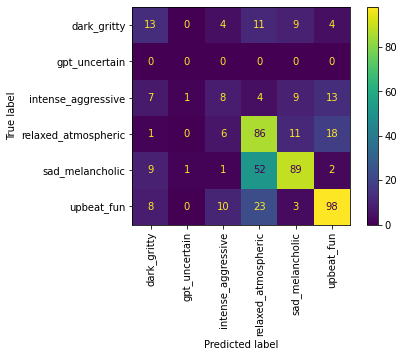

In [385]:
plot_conf_mat(zs_gpt_df["sentiment"], fixed_gpt_result)

### Lyrics with stats

In [566]:
# feature description taken from: https://developer.spotify.com/documentation/web-api/reference/get-several-audio-features

ZS_SYSTEM_MESSAGE_W_STATS = \
f"""
You are a professional lyricist and music critic.
Instructions: 
1. Input format: JSON object containing the following information about a track (song):
 - artist: Artist's name
 - track: Track's name
 - danceability: Indicates how suitable the track is for dancing, ranging from 0.0 (least danceable) to 1.0 (most danceable)
 - energy: Intensity level of the track, ranging from 0.0 (least energetic) to 1.0 (most energetic)
 - loudness: Overall volume of the track, ranging from 0.0 (quiet) to 1.0 (loudest)
 - valence: Positiveness or happiness of the track, ranging from 0.0 (saddest) to 1.0 (happiest)
 - tempo: Speed of the track in beats per minute (BPM) (higher values indicate a fast-paced song)
 - mode: Modality of the track (Major or Minor)
 - genres: List of music genres that the track belongs to
 - lyrics: Track's lyrics
2. Task: Analyze track features and select a single sentiment from the provided list that best describes the track.
 - Sentiments: {sentiments}
3. Response format: Provide the exact name of a single sentiment in lowercase with kebab notation.
4. If uncertain: Respond with 'gpt_uncertain'.
"""
print(ZS_SYSTEM_MESSAGE_W_STATS)


You are a professional lyricist and music critic.
Instructions: 
1. Input format: JSON object containing the following information about a track (song):
 - artist: Artist's name
 - track: Track's name
 - danceability: Indicates how suitable the track is for dancing, ranging from 0.0 (least danceable) to 1.0 (most danceable)
 - energy: Intensity level of the track, ranging from 0.0 (least energetic) to 1.0 (most energetic)
 - loudness: Overall volume of the track, ranging from 0.0 (quiet) to 1.0 (loudest)
 - valence: Positiveness or happiness of the track, ranging from 0.0 (saddest) to 1.0 (happiest)
 - tempo: Speed of the track in beats per minute (BPM) (higher values indicate a fast-paced song)
 - mode: Modality of the track (Major or Minor)
 - genres: List of music genres that the track belongs to
 - lyrics: Track's lyrics
2. Task: Analyze track features and select a single sentiment from the provided list that best describes the track.
 - Sentiments: ['sad_melancholic', 'upbeat_fun

In [567]:
def parse_csv_list_str(csv_list_str):
    return [x.strip("''") for x in csv_list_str.strip("[]").split("' '")]

In [483]:
parse_csv_list_str("['Alternative' 'Children’s Music' 'Indie' 'Rock']")

['Alternative', 'Children’s Music', 'Indie', 'Rock']

In [685]:
def get_song_json(row):
    return json.dumps({
        "artist": row["artist"],
        "track": row["track"],
        "danceability": row["danceability"],
        "energy": row["energy"],
        "loudness": row["loudness"],
        "valence": row["valence"],
        "tempo": row["tempo"],
        "mode": row["mode"],
        "genres": parse_csv_list_str(row["genres"]),
        "lyrics": row["lyrics_clean"][:2000],
    })

def get_zero_shot_w_stats_content(row):
    return f"""{get_song_json(row)}\nSentiment is: """

def get_zero_shot_messages_w_stats(row):
    return [
        {"role": "system", "content": ZS_SYSTEM_MESSAGE_W_STATS},
        {"role": "user", "content": get_zero_shot_w_stats_content(row)},
    ]

In [570]:
test_track = df.iloc[439]
print(get_song_json(test_track))

{"artist": "Avril Lavigne", "track": "Tomorrow", "danceability": 0.632, "energy": 0.7929999999999999, "loudness": 0.8305740295269091, "valence": 0.609, "tempo": 136.012, "mode": "Minor", "genres": ["Dance"], "lyrics": "And I wanna believe you \nWhen you tell me that it'll be okay \nYeah, I try to believe you \nBut I don't \nWhen you say that it's gonna be \nIt always turns out to be a different way \nI try to believe you \nNot today, today, today, today, today \n(I, yeah, yeah) \nI don't know how I'll feel (Yeah, yeah, yeah, yeah) \nTomorrow (Tomorrow), tomorrow (Tomorrow) \nAnd I (Yeah, yeah, yeah) \nDon't know what to say (Yeah, yeah, yeah, yeah) \nTomorrow (Tomorrow) \nTomorrow is a different day \n(Tomorrow) \nIt's always been up to you \nIt's turnin' around, it's up to me \nI'm gonna do what I have to do \nJust don't \nGimme a little time \nLeave me alone a little while \nMaybe it's not too late \nNot today, today, today, today, today, oh \nHey, yeah, yeah, hey, yeah, yeah \nAnd I

In [571]:
test_single_gpt_request(test_track, get_zero_shot_messages_w_stats)

{
  "prompt_tokens": 716,
  "completion_tokens": 5,
  "total_tokens": 721
}
GPT-3 result: sad_melancholic - Original class: sad_melancholic


In [218]:
# zs_gpt_w_stats = gpt_save_result(df, get_zero_shot_messages_w_stats, "zs_w_stats")
# zs_gpt_w_stats.head()

  1/496 | 0.20 % | Fetching GPT result for: 3 Doors Down - Let Me Be Myself ...
Fetching finished.
  2/496 | 0.40 % | Fetching GPT result for: Wilco - How To Fight Loneliness ...
Fetching finished.
  3/496 | 0.60 % | Fetching GPT result for: OK Go - Get Over It ...
Fetching finished.
  4/496 | 0.81 % | Fetching GPT result for: Eminem - Deja Vu ...
Fetching finished.
  5/496 | 1.01 % | Fetching GPT result for: Lauryn Hill feat. D'Angelo - Nothing Even Matters ...
Fetching finished.
  6/496 | 1.21 % | Fetching GPT result for: Curtis Mayfield - Here But I'm Gone ...
Fetching finished.
  7/496 | 1.41 % | Fetching GPT result for: Drake - A Night Off (feat. Lloyd) ...
Fetching finished.
  8/496 | 1.61 % | Fetching GPT result for: Pepper - Give It Up (Radio Edit) ...
Fetching finished.
  9/496 | 1.81 % | Fetching GPT result for: Blur - No Distance Left to Run ...
Fetching finished.
 10/496 | 2.02 % | Fetching GPT result for: Panic! at the Disco - Casual Affair ...
Fetching finished.
 11/496 |

Fetching finished.
 83/496 | 16.73 % | Fetching GPT result for: Henry Mancini - Days of Wine and Roses ...
Fetching finished.
 84/496 | 16.94 % | Fetching GPT result for: Jace Everett - Bad Things ...
Fetching finished.
 85/496 | 17.14 % | Fetching GPT result for: Gojira - Born in Winter ...
Fetching finished.
 86/496 | 17.34 % | Fetching GPT result for: Omarion - Touch ...
Fetching finished.
 87/496 | 17.54 % | Fetching GPT result for: Santigold - Lights Out ...
Fetching finished.
 88/496 | 17.74 % | Fetching GPT result for: Ms. Lauryn Hill - Doo Wop (That Thing) ...
Fetching finished.
 89/496 | 17.94 % | Fetching GPT result for: LCD Soundsystem - New York, I Love You But You're Bringing Me Down ...
Fetching finished.
 90/496 | 18.15 % | Fetching GPT result for: Billy Joel - Lullabye (Goodnight, My Angel) ...
Fetching finished.
 91/496 | 18.35 % | Fetching GPT result for: Jodeci - Feenin' ...
Fetching finished.
 92/496 | 18.55 % | Fetching GPT result for: Charlie Daniels Band - Uneasy

Fetching finished.
166/496 | 33.47 % | Fetching GPT result for: Brad Mehldau - Exit Music For a Film ...
Fetching finished.
167/496 | 33.67 % | Fetching GPT result for: Andrew Bird - Capsized ...
Fetching finished.
168/496 | 33.87 % | Fetching GPT result for: The Sonics - The Witch ...
Fetching finished.
169/496 | 34.07 % | Fetching GPT result for: Fall Out Boy - Chicago Is So Two Years Ago ...
Fetching finished.
170/496 | 34.27 % | Fetching GPT result for: Grimes - Kill V. Maim ...
Fetching finished.
171/496 | 34.48 % | Fetching GPT result for: Kimya Dawson - Loose Lips ...
Fetching finished.
172/496 | 34.68 % | Fetching GPT result for: Lil' Kim - How Many Licks (feat. Sisqo) ...
Fetching finished.
173/496 | 34.88 % | Fetching GPT result for: Zayn - Still Got Time (feat. PARTYNEXTDOOR) ...
Fetching finished.
174/496 | 35.08 % | Fetching GPT result for: Kool & The Gang - Cherish ...
Fetching finished.
175/496 | 35.28 % | Fetching GPT result for: Grouplove - Lovely Cup ...
Fetching fini

Fetching finished.
250/496 | 50.40 % | Fetching GPT result for: The Heavy - Stuck ...
Fetching finished.
251/496 | 50.60 % | Fetching GPT result for: Yo La Tengo - You Can Have It All ...
Fetching finished.
252/496 | 50.81 % | Fetching GPT result for: Portishead - Roads ...
Fetching finished.
253/496 | 51.01 % | Fetching GPT result for: INXS - Need You Tonight ...
Fetching finished.
254/496 | 51.21 % | Fetching GPT result for: Ennio Morricone - Ave Maria Guarani ...
Fetching finished.
255/496 | 51.41 % | Fetching GPT result for: Heartless Bastards - Hold Your Head High ...
Fetching finished.
256/496 | 51.61 % | Fetching GPT result for: Gojira - Silvera ...
Fetching finished.
257/496 | 51.81 % | Fetching GPT result for: 98 Degrees & Stevie Wonder - True To Your Heart ...
Fetching finished.
258/496 | 52.02 % | Fetching GPT result for: The Neighbourhood - Afraid ...
Fetching finished.
259/496 | 52.22 % | Fetching GPT result for: Passion Pit - Little Secrets ...
Fetching finished.
260/496 

Fetching finished.
333/496 | 67.14 % | Fetching GPT result for: Lady Gaga - Swine ...
Fetching finished.
334/496 | 67.34 % | Fetching GPT result for: Tenacious D - Karate Schnitzel ...
Fetching finished.
335/496 | 67.54 % | Fetching GPT result for: Leftöver Crack - Baby-Punchers ...
Fetching finished.
336/496 | 67.74 % | Fetching GPT result for: Destroyer - Painter in Your Pocket ...
Fetching finished.
337/496 | 67.94 % | Fetching GPT result for: Tame Impala - Half Full Glass Of Wine ...
Fetching finished.
338/496 | 68.15 % | Fetching GPT result for: Cute Is What We Aim For - The Curse Of Curves ...
Fetching finished.
339/496 | 68.35 % | Fetching GPT result for: Five Iron Frenzy - Pre-Ex-Girlfriend ...
Fetching finished.
340/496 | 68.55 % | Fetching GPT result for: Lemon Jelly - The Staunton Lick ...
Fetching finished.
341/496 | 68.75 % | Fetching GPT result for: Tame Impala - Music To Walk Home By ...
Fetching finished.
342/496 | 68.95 % | Fetching GPT result for: Dave Matthews Band -

Fetching finished.
416/496 | 83.87 % | Fetching GPT result for: The Weeknd - Loft Music ...
Fetching finished.
417/496 | 84.07 % | Fetching GPT result for: Bob Dylan - If You See Her, Say Hello ...
Fetching finished.
418/496 | 84.27 % | Fetching GPT result for: Mariah Carey - Underneath the Stars ...
Fetching finished.
419/496 | 84.48 % | Fetching GPT result for: Bill Withers - Lovely Day ...
Fetching finished.
420/496 | 84.68 % | Fetching GPT result for: Florence + the Machine - Queen of Peace ...
Fetching finished.
421/496 | 84.88 % | Fetching GPT result for: Zaz - Éblouie par la nuit ...
Fetching finished.
422/496 | 85.08 % | Fetching GPT result for: John Lennon - Love ...
Fetching finished.
423/496 | 85.28 % | Fetching GPT result for: Brian McBride - Our Last Moment in Song ...
Fetching finished.
424/496 | 85.48 % | Fetching GPT result for: Depeche Mode - World in My Eyes ...
Fetching finished.
425/496 | 85.69 % | Fetching GPT result for: Beyonce - Be With You ...
Fetching finished

,track,artist,danceability,energy,loudness,mode,tempo,valence,genres,lyrics_raw,sentiment,lyrics_clean,gpt_result,gpt_prompt_tokens,gpt_completion_tokens,gpt_total_tokens
0,Let Me Be Myself,3 Doors Down,0.496,0.675,0.854842,Major,153.988,0.493,['Alternative' 'Children’s Music'],[Verse 1]\r\nI guess I just got lost\r\nBeing ...,sad_melancholic,I guess I just got lost \nBeing someone else \...,relaxed-atmospheric,664,5,669
1,How To Fight Loneliness,Wilco,0.692,0.378,0.701170,Minor,123.658,0.400,['Country' 'Alternative' 'Folk' 'Indie'],[Verse 1]\r\nHow to fight loneliness\r\nSmile ...,sad_melancholic,How to fight loneliness \nSmile all the time \...,sad_melancholic,544,5,549
2,Get Over It,OK Go,0.389,0.767,0.898260,Major,184.926,0.544,['Alternative' 'Children’s Music' 'Indie' 'Rock'],"[Verse 1]\r\nLot of knots, lot of snags\r\nLot...",upbeat_fun,"Lot of knots, lot of snags \nLot of holes, lot...",upbeat_fun,738,3,741
3,Deja Vu,Eminem,0.702,0.866,0.954625,Minor,83.997,0.606,['Hip-Hop'],"[Intro: Matthew St. Patrick]\r\nDMC, we have a...",upbeat_fun,"DMC, we have a mid-thirties male found down, u...",sad_melancholic,1646,5,1651
4,Nothing Even Matters,Lauryn Hill feat. D'Angelo,0.539,0.363,0.672468,Minor,136.422,0.549,['R&B' 'Hip-Hop' 'Rap' 'Soul'],"[Intro: D'Angelo,\r\nLauryn Hill\r\n]\r\nOh, o...",relaxed_atmospheric,"Oh, oh, oh \nMmm, yeah, yeah \nOh, oh \nOh-oh,...",relaxed_atmospheric,983,5,988


In [376]:
zs_gpt_w_stats = pd.read_csv('data/zs_w_stats_gpt_result.csv')
# zs_gpt_w_stats = correct_existing_result(zs_gpt_w_stats, corrected_sentiment_df)
zs_gpt_w_stats.head()

,track,artist,danceability,energy,loudness,mode,tempo,valence,genres,lyrics_raw,sentiment,lyrics_clean,gpt_result,gpt_prompt_tokens,gpt_completion_tokens,gpt_total_tokens
0,Let Me Be Myself,3 Doors Down,0.496,0.675,0.854842,Major,153.988,0.493,['Alternative' 'Children’s Music'],[Verse 1]\r\nI guess I just got lost\r\nBeing ...,sad_melancholic,I guess I just got lost \nBeing someone else \...,relaxed-atmospheric,664,5,669
1,How To Fight Loneliness,Wilco,0.692,0.378,0.701170,Minor,123.658,0.400,['Country' 'Alternative' 'Folk' 'Indie'],[Verse 1]\r\nHow to fight loneliness\r\nSmile ...,sad_melancholic,How to fight loneliness \nSmile all the time \...,sad_melancholic,544,5,549
2,Get Over It,OK Go,0.389,0.767,0.898260,Major,184.926,0.544,['Alternative' 'Children’s Music' 'Indie' 'Rock'],"[Verse 1]\r\nLot of knots, lot of snags\r\nLot...",upbeat_fun,"Lot of knots, lot of snags \nLot of holes, lot...",upbeat_fun,738,3,741
3,Deja Vu,Eminem,0.702,0.866,0.954625,Minor,83.997,0.606,['Hip-Hop'],"[Intro: Matthew St. Patrick]\r\nDMC, we have a...",dark_gritty,"DMC, we have a mid-thirties male found down, u...",sad_melancholic,1646,5,1651
4,Nothing Even Matters,Lauryn Hill feat. D'Angelo,0.539,0.363,0.672468,Minor,136.422,0.549,['R&B' 'Hip-Hop' 'Rap' 'Soul'],"[Intro: D'Angelo,\r\nLauryn Hill\r\n]\r\nOh, o...",relaxed_atmospheric,"Oh, oh, oh \nMmm, yeah, yeah \nOh, oh \nOh-oh,...",relaxed_atmospheric,983,5,988


In [377]:
zs_gpt_w_stats.to_csv('data/zs_w_stats_gpt_result.csv', index=False)

In [378]:
zs_gpt_w_stats["gpt_result"].value_counts()

sad_melancholic        196
upbeat_fun             142
relaxed-atmospheric     59
relaxed_atmospheric     55
intense_aggressive      17
dark-gritty             13
upbeat-fun              12
dark_gritty              6
sad-melancholic          1
Name: gpt_result, dtype: int64

In [379]:
fixed_gpt_result_w_stats = zs_gpt_w_stats["gpt_result"].str.lower().replace('[- ]', '_', regex=True)
fixed_gpt_result_w_stats.value_counts()

sad_melancholic        197
upbeat_fun             154
relaxed_atmospheric    114
dark_gritty             19
intense_aggressive      17
Name: gpt_result, dtype: int64

                     precision    recall  f1-score   support

        dark_gritty       0.58      0.27      0.37        41
 intense_aggressive       0.35      0.14      0.20        42
relaxed_atmospheric       0.68      0.63      0.65       122
    sad_melancholic       0.70      0.90      0.79       154
         upbeat_fun       0.82      0.89      0.85       142

           accuracy                           0.71       501
          macro avg       0.63      0.57      0.57       501
       weighted avg       0.69      0.71      0.69       501



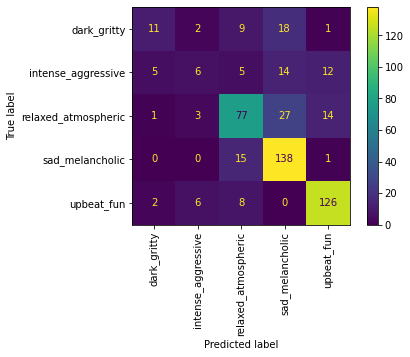

In [380]:
plot_conf_mat(zs_gpt_w_stats["sentiment"], fixed_gpt_result_w_stats)

In [234]:
def get_total_usage_price_usd(result_df):
    return 0.0015 * result_df["gpt_prompt_tokens"].sum() / 1000 + 0.002 * result_df["gpt_completion_tokens"].sum() / 1000

In [235]:
get_total_usage_price_usd(zs_gpt_w_stats)

0.581677

In [520]:
zs_gpt_w_stats["gpt_completion_tokens"].mean()

4.299401197604791

## Few (2) Shot generative approach

In [498]:
FS_SYSTEM_MESSAGE_W_STATS = ZS_SYSTEM_MESSAGE_W_STATS

In [613]:
val_df = pd.read_csv("data/val_ds.csv").rename(columns={"lyrics": "lyrics_raw"})
val_df["lyrics_clean"] = val_df["lyrics_raw"].apply(transform_lyrics)
val_df

,track,artist,number_of_emotion_tags,valence_tags,arousal_tags,dominance_tags,acousticness,danceability,energy,instrumentalness,...,Reggae,Dance,Country,Opera,Movie,Children's Music,lyrics_raw,sentiment,target,lyrics_clean
0,Black Cherry,Goldfrapp,17,6.149520,3.961280,5.660640,0.225000,0.429,0.526,0.102000,...,0,0,0,0,0,0,[Verse 1]\r\nHow can it be? I can taste you no...,relaxed_atmospheric,2,How can it be? I can taste you now \nHow can I...
1,Haunting,Halsey,1,5.080000,4.090000,4.610000,0.015000,0.461,0.696,0.000491,...,0,1,0,0,0,0,[Intro]\r\nKeep on haunting\r\nKeep on hauntin...,dark_gritty,0,Keep on haunting \nKeep on haunting me \nI was...
2,Eternal Sunshine,Jhené Aiko,4,6.577500,3.482500,6.232500,0.798000,0.439,0.402,0.001220,...,0,0,0,0,0,0,[Verse 1]\r\nIs it strange for me to say that ...,sad_melancholic,3,Is it strange for me to say that if I were to ...
3,Ooh La La,Goldfrapp,12,7.161967,6.020000,5.934754,0.009960,0.480,0.676,0.642000,...,0,1,0,0,0,0,[Verse 1]\r\nDial up my number now\r\nWeaving ...,relaxed_atmospheric,2,Dial up my number now \nWeaving it through the...
4,Footsteps in the Dark,The Isley Brothers,6,7.157778,3.964444,5.913333,0.402000,0.679,0.374,0.000025,...,0,0,0,0,0,0,[Verse 1]\r\nAre we really sure\r\nCan a love ...,relaxed_atmospheric,2,Are we really sure \nCan a love that lasted fo...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,In the Dark,Dev,11,6.884528,5.486415,6.029434,0.003580,0.736,0.823,0.000914,...,0,1,0,0,0,0,"[Chorus]\r\nOn my waist, through my hair\r\nTh...",relaxed_atmospheric,2,"On my waist, through my hair \nThink about it ..."
491,Rabbit In Your Headlights,"Unkle, Thom Yorke",16,4.046571,3.348857,4.076857,0.076200,0.265,0.588,0.011300,...,0,0,0,0,0,0,[Chorus 1]\r\nI'm a rabbit in your headlights\...,dark_gritty,0,I'm a rabbit in your headlights \nScared of th...
492,I Started A Joke,Bee Gees,15,5.800351,3.899474,5.369649,0.174000,0.315,0.456,0.000010,...,0,0,0,0,0,0,[Verse 1]\r\nI started a joke\r\nWhich started...,upbeat_fun,4,I started a joke \nWhich started the whole wor...
493,New Architects,Strike Anywhere,3,7.743333,5.560000,6.303333,0.000039,0.396,0.883,0.000024,...,0,0,0,0,0,0,There's a young world standing strong in the t...,upbeat_fun,4,There's a young world standing strong in the t...


In [639]:
few_shot_tracks = {
    'relaxed_atmospheric': [
        {'artist': "John Legend", 'track': "Another Again"},
        {'artist': "Sade", 'track': "Give it Up"}
    ],
    'sad_melancholic': [
        {'artist': "Adele", 'track': "Hello"},
        {'artist': "Eric Clapton", 'track': "Tears in Heaven"}
    ],
}

In [634]:
def dict_track_2_rows(val_dict_track):
    val_dict_rows = {}
    for key, learning_samples in val_dict_track.items():
        rows = []
        for sample in learning_samples:
            row_condition = (val_df['artist'] == sample['artist']) & (val_df['track'] == sample['track'])
            row = val_df[row_condition].squeeze()
            rows.append(row)

        val_dict_rows[key] = rows
    return val_dict_rows

def val_dict_2_messages(val_dict_track):
    val_dict_rows = dict_track_2_rows(val_dict_track)
    messages = []
    for key, learning_samples in val_dict_rows.items():
        for sample in learning_samples:
            messages.extend([
                {"role": "user", "content": get_zero_shot_w_stats_content(sample)},
                {"role": "assistant", "content": key},
            ])
    return messages

In [666]:
def few_shot_messages_w_stats_factory(val_dict_track):
    samples = val_dict_2_messages(val_dict_track)
    def get_few_shot_messages_w_stats(row):
        return [
            {"role": "system", "content": FS_SYSTEM_MESSAGE_W_STATS},
            *samples,
            {"role": "user", "content": get_zero_shot_w_stats_content(row)},
        ]
    
    return get_few_shot_messages_w_stats

In [640]:
get_few_shot_messages_w_stats = few_shot_messages_w_stats_factory(few_shot_tracks)

In [641]:
test_track = df.iloc[125]
test_track
print(get_few_shot_messages_w_stats(test_track))

[{'role': 'system', 'content': "\nYou are a professional lyricist and music critic.\nInstructions: \n1. Input format: JSON object containing the following information about a track (song):\n - artist: Artist's name\n - track: Track's name\n - danceability: Indicates how suitable the track is for dancing, ranging from 0.0 (least danceable) to 1.0 (most danceable)\n - energy: Intensity level of the track, ranging from 0.0 (least energetic) to 1.0 (most energetic)\n - loudness: Overall volume of the track, ranging from 0.0 (quiet) to 1.0 (loudest)\n - valence: Positiveness or happiness of the track, ranging from 0.0 (saddest) to 1.0 (happiest)\n - tempo: Speed of the track in beats per minute (BPM) (higher values indicate a fast-paced song)\n - mode: Modality of the track (Major or Minor)\n - genres: List of music genres that the track belongs to\n - lyrics: Track's lyrics\n2. Task: Analyze track features and select a single sentiment from the provided list that best describes the track.\

In [618]:
test_single_gpt_request(test_track, get_few_shot_messages_w_stats)

{
  "prompt_tokens": 3584,
  "completion_tokens": 3,
  "total_tokens": 3587
}
GPT-3 result: dark_gritty - Original class: intense_aggressive


In [549]:
zs_gpt_w_stats.iloc[100]

track                                        These Are The Days Of Our Liv
artist                                                               Queen
danceability                                                         0.677
energy                                                               0.403
loudness                                                          0.776968
mode                                                                 Major
tempo                                                              112.619
valence                                                              0.568
genres                                                            ['Rock']
lyrics_raw               [Verse 1]\r\nSometimes I get to feeling\r\nI w...
sentiment                                                  sad_melancholic
lyrics_clean             Sometimes I get to feeling \nI was back in the...
gpt_result                                             relaxed-atmospheric
gpt_prompt_tokens        

In [619]:
# fs_gpt_w_stats = gpt_save_result(df, get_few_shot_messages_w_stats, "fs_w_stats")
# fs_gpt_w_stats.head(20)

  1/501 | 0.20 % | Fetching GPT result for: 3 Doors Down - Let Me Be Myself ...
Fetching finished.
  2/501 | 0.40 % | Fetching GPT result for: Wilco - How To Fight Loneliness ...
Fetching finished.
  3/501 | 0.60 % | Fetching GPT result for: OK Go - Get Over It ...
Fetching finished.
  4/501 | 0.80 % | Fetching GPT result for: Eminem - Deja Vu ...
Fetching finished.
  5/501 | 1.00 % | Fetching GPT result for: Lauryn Hill feat. D'Angelo - Nothing Even Matters ...
Fetching finished.
  6/501 | 1.20 % | Fetching GPT result for: Curtis Mayfield - Here But I'm Gone ...
Fetching finished.
  7/501 | 1.40 % | Fetching GPT result for: Drake - A Night Off (feat. Lloyd) ...
Fetching finished.
  8/501 | 1.60 % | Fetching GPT result for: Pepper - Give It Up (Radio Edit) ...
Fetching finished.
  9/501 | 1.80 % | Fetching GPT result for: Blur - No Distance Left to Run ...
Fetching finished.
 10/501 | 2.00 % | Fetching GPT result for: Panic! at the Disco - Casual Affair ...
Fetching finished.
 11/501 |

Fetching finished.
 84/501 | 16.77 % | Fetching GPT result for: Jace Everett - Bad Things ...
Fetching finished.
 85/501 | 16.97 % | Fetching GPT result for: Gojira - Born in Winter ...
Fetching finished.
 86/501 | 17.17 % | Fetching GPT result for: Omarion - Touch ...
Fetching finished.
 87/501 | 17.37 % | Fetching GPT result for: Santigold - Lights Out ...
Fetching finished.
 88/501 | 17.56 % | Fetching GPT result for: Ms. Lauryn Hill - Doo Wop (That Thing) ...
Fetching finished.
 89/501 | 17.76 % | Fetching GPT result for: LCD Soundsystem - New York, I Love You But You're Bringing Me Down ...
Fetching finished.
 90/501 | 17.96 % | Fetching GPT result for: Billy Joel - Lullabye (Goodnight, My Angel) ...
Fetching finished.
 91/501 | 18.16 % | Fetching GPT result for: Jodeci - Feenin' ...
Fetching finished.
 92/501 | 18.36 % | Fetching GPT result for: Charlie Daniels Band - Uneasy Rider ...
Fetching finished.
 93/501 | 18.56 % | Fetching GPT result for: JoJo - Breezy ...
Fetching finis

Fetching finished.
168/501 | 33.53 % | Fetching GPT result for: Andrew Bird - Capsized ...
Fetching finished.
169/501 | 33.73 % | Fetching GPT result for: The Sonics - The Witch ...
Fetching finished.
170/501 | 33.93 % | Fetching GPT result for: Fall Out Boy - Chicago Is So Two Years Ago ...
Fetching finished.
171/501 | 34.13 % | Fetching GPT result for: Grimes - Kill V. Maim ...
Fetching finished.
172/501 | 34.33 % | Fetching GPT result for: Kimya Dawson - Loose Lips ...
Fetching finished.
173/501 | 34.53 % | Fetching GPT result for: Lil' Kim - How Many Licks (feat. Sisqo) ...
Fetching finished.
174/501 | 34.73 % | Fetching GPT result for: Zayn - Still Got Time (feat. PARTYNEXTDOOR) ...
Fetching finished.
175/501 | 34.93 % | Fetching GPT result for: Kool & The Gang - Cherish ...
Fetching finished.
176/501 | 35.13 % | Fetching GPT result for: Grouplove - Lovely Cup ...
Fetching finished.
177/501 | 35.33 % | Fetching GPT result for: Barenaked Ladies - The Old Apartment ...
Fetching fini

Fetching finished.
250/501 | 49.90 % | Fetching GPT result for: Supergrass - Mary ...
Fetching finished.
251/501 | 50.10 % | Fetching GPT result for: The Heavy - Stuck ...
Num tried: 1 | Error Rate limit reached for default-gpt-3.5-turbo in organization org-sP5SM3vcNN0ZwEzqOifqligh on tokens per min. Limit: 90000 / min. Current: 88339 / min. Contact us through our help center at help.openai.com if you continue to have issues.
Fetching finished.
252/501 | 50.30 % | Fetching GPT result for: Yo La Tengo - You Can Have It All ...
Fetching finished.
253/501 | 50.50 % | Fetching GPT result for: Portishead - Roads ...
Fetching finished.
254/501 | 50.70 % | Fetching GPT result for: INXS - Need You Tonight ...
Fetching finished.
255/501 | 50.90 % | Fetching GPT result for: Ennio Morricone - Ave Maria Guarani ...
Fetching finished.
256/501 | 51.10 % | Fetching GPT result for: Heartless Bastards - Hold Your Head High ...
Fetching finished.
257/501 | 51.30 % | Fetching GPT result for: Heartless Ba

Fetching finished.
318/501 | 63.47 % | Fetching GPT result for: The Weeknd - The Morning ...
Fetching finished.
319/501 | 63.67 % | Fetching GPT result for: Vampire Weekend - M79 ...
Fetching finished.
320/501 | 63.87 % | Fetching GPT result for: Anita Baker - Caught Up in the Rapture ...
Fetching finished.
321/501 | 64.07 % | Fetching GPT result for: The Smashing Pumpkins - Luna ...
Fetching finished.
322/501 | 64.27 % | Fetching GPT result for: Ayreon - Comatose ...
Fetching finished.
323/501 | 64.47 % | Fetching GPT result for: Johnny Cash - Hurt ...
Fetching finished.
324/501 | 64.67 % | Fetching GPT result for: Jimi Hendrix - 1983 ...
Fetching finished.
325/501 | 64.87 % | Fetching GPT result for: Monica - Everytime Tha Beat Drop ...
Fetching finished.
326/501 | 65.07 % | Fetching GPT result for: Iron & Wine - Sunset Soon Forgotten ...
Fetching finished.
327/501 | 65.27 % | Fetching GPT result for: Santigold - Shove It ...
Fetching finished.
328/501 | 65.47 % | Fetching GPT result

Fetching finished.
401/501 | 80.04 % | Fetching GPT result for: Norah Jones - December ...
Fetching finished.
402/501 | 80.24 % | Fetching GPT result for: Marilyn Manson - Angel With the Scabbed Wings ...
Fetching finished.
403/501 | 80.44 % | Fetching GPT result for: Andrew Bird - Fake Palindromes ...
Fetching finished.
404/501 | 80.64 % | Fetching GPT result for: Lifehouse - Blind ...
Fetching finished.
405/501 | 80.84 % | Fetching GPT result for: Bob & Marcia - Young Gifted and Black ...
Fetching finished.
406/501 | 81.04 % | Fetching GPT result for: Margot & the Nuclear So and So's - Broadripple Is Burning ...
Fetching finished.
407/501 | 81.24 % | Fetching GPT result for: Phoenix - Rome ...
Fetching finished.
408/501 | 81.44 % | Fetching GPT result for: Thievery Corporation - Sweet Tides ...
Fetching finished.
409/501 | 81.64 % | Fetching GPT result for: Lil' Wayne - 6 Foot 7 Foot ...
Fetching finished.
410/501 | 81.84 % | Fetching GPT result for: Band of Horses - Monsters ...
Fet

Fetching finished.
484/501 | 96.61 % | Fetching GPT result for: Paolo Nutini - Pencil Full of Lead ...
Fetching finished.
485/501 | 96.81 % | Fetching GPT result for: Our Lady Peace - Somewhere Out There ...
Fetching finished.
486/501 | 97.01 % | Fetching GPT result for: Evans Blue - Erase My Scars ...
Fetching finished.
487/501 | 97.21 % | Fetching GPT result for: Everything But the Girl - We Walk the Same Line ...
Fetching finished.
488/501 | 97.41 % | Fetching GPT result for: John Mayer - Clarity ...
Fetching finished.
489/501 | 97.60 % | Fetching GPT result for: St. Vincent - Laughing With a Mouth of Blood ...
Fetching finished.
490/501 | 97.80 % | Fetching GPT result for: Eminem - Big Weenie ...
Fetching finished.
491/501 | 98.00 % | Fetching GPT result for: Carrie Underwood - Wine After Whiskey ...
Fetching finished.
492/501 | 98.20 % | Fetching GPT result for: City and Colour - Sometimes (I Wish) ...
Fetching finished.
493/501 | 98.40 % | Fetching GPT result for: James Taylor - 

,track,artist,danceability,energy,loudness,mode,tempo,valence,genres,lyrics_raw,sentiment,lyrics_clean,gpt_result,gpt_prompt_tokens,gpt_completion_tokens,gpt_total_tokens
0,Let Me Be Myself,3 Doors Down,0.496,0.6750,0.854842,Major,153.988,0.493,['Alternative' 'Children’s Music'],[Verse 1]\r\nI guess I just got lost\r\nBeing ...,sad_melancholic,I guess I just got lost \nBeing someone else \...,upbeat_fun,2175,3,2178
1,How To Fight Loneliness,Wilco,0.692,0.3780,0.701170,Minor,123.658,0.400,['Country' 'Alternative' 'Folk' 'Indie'],[Verse 1]\r\nHow to fight loneliness\r\nSmile ...,sad_melancholic,How to fight loneliness \nSmile all the time \...,upbeat_fun,2055,3,2058
2,Get Over It,OK Go,0.389,0.7670,0.898260,Major,184.926,0.544,['Alternative' 'Children’s Music' 'Indie' 'Rock'],"[Verse 1]\r\nLot of knots, lot of snags\r\nLot...",upbeat_fun,"Lot of knots, lot of snags \nLot of holes, lot...",upbeat_fun,2249,3,2252
3,Deja Vu,Eminem,0.702,0.8660,0.954625,Minor,83.997,0.606,['Hip-Hop'],"[Intro: Matthew St. Patrick]\r\nDMC, we have a...",dark_gritty,"DMC, we have a mid-thirties male found down, u...",dark_gritty,3157,3,3160
4,Nothing Even Matters,Lauryn Hill feat. D'Angelo,0.539,0.3630,0.672468,Minor,136.422,0.549,['R&B' 'Hip-Hop' 'Rap' 'Soul'],"[Intro: D'Angelo,\r\nLauryn Hill\r\n]\r\nOh, o...",relaxed_atmospheric,"Oh, oh, oh \nMmm, yeah, yeah \nOh, oh \nOh-oh,...",upbeat_fun,2494,3,2497
5,Here But I'm Gone,Curtis Mayfield,0.772,0.3680,0.736262,Minor,143.834,0.564,['Soul'],[Chorus]\r\nHow did I get so far gone?\r\nWher...,dark_gritty,How did I get so far gone? \nWhere do I belong...,sad_melancholic,2178,5,2183
6,A Night Off (feat. Lloyd),Drake,0.611,0.5080,0.868568,Minor,103.612,0.368,['Hip-Hop' 'Pop' 'Rap'],[Verse 1: Drake]\r\nSpending every moment in t...,relaxed_atmospheric,Spending every moment in the studio \nI never ...,upbeat_fun,2228,3,2231
7,Give It Up (Radio Edit),Pepper,0.613,0.7110,0.863167,Minor,88.455,0.580,['Reggae' 'Ska'],[Verse]\r\nIt's been a while since I've seen y...,upbeat_fun,It's been a while since I've seen your face (F...,upbeat_fun,2386,3,2389
8,No Distance Left to Run,Blur,0.419,0.2080,0.652115,Major,148.070,0.108,['Electronic'],[Verse 1]\r\nIt's over\r\nYou don't need to te...,sad_melancholic,It's over \nYou don't need to tell me \nI hope...,sad_melancholic,2119,5,2124
9,Casual Affair,Panic! at the Disco,0.508,0.8580,0.874794,Minor,147.059,0.385,['Pop' 'Rock'],"[Spoken Intro]\r\nLooks innocent enough, doesn...",upbeat_fun,"Looks innocent enough, doesn't it? \nBut somet...",upbeat_fun,2209,3,2212


In [620]:
fs_gpt_w_stats["gpt_result"].value_counts()

upbeat_fun             266
relaxed_atmospheric     85
sad_melancholic         65
dark_gritty             62
intense_aggressive      16
gpt_uncertain            7
Name: gpt_result, dtype: int64

C:\Users\HedonisT\anaconda3\envs\internship\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HedonisT\anaconda3\envs\internship\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HedonisT\anaconda3\envs\internship\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

        dark_gritty       0.24      0.37      0.29        41
      gpt_uncertain       0.00      0.00      0.00         0
 intense_aggressive       0.38      0.14      0.21        42
relaxed_atmospheric       0.38      0.26      0.31       122
    sad_melancholic       0.85      0.36      0.50       154
         upbeat_fun       0.50      0.94      0.65       142

           accuracy                           0.48       501
          macro avg       0.39      0.34      0.33       501
       weighted avg       0.54      0.48      0.46       501



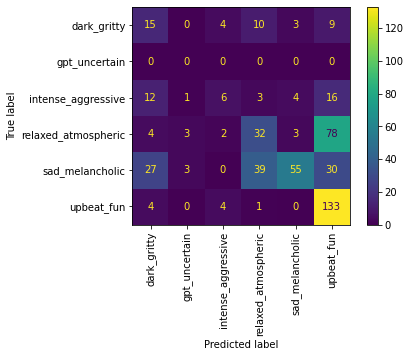

In [621]:
plot_conf_mat(fs_gpt_w_stats["sentiment"], fs_gpt_w_stats["gpt_result"])

In [622]:
get_total_usage_price_usd(fs_gpt_w_stats)

1.7214654999999999

## One Shot generative approach

In [686]:
one_shot_tracks = {
    'relaxed_atmospheric': [{'artist': "John Legend", 'track': "Another Again"}],
    'upbeat_fun': [{'artist': "Spice Girls", 'track': "Spice Up Your Life"}],
    'sad_melancholic': [{'artist': "Eric Clapton", 'track': "Tears in Heaven"}],
    'intense_aggressive': [{'artist': "Slipknot", 'track': "Custer"}],
    'dark_gritty': [{'artist': "Evanescence", 'track': "End of the Dream"}],
}

In [669]:
get_one_shot_messages_w_stats = few_shot_messages_w_stats_factory(one_shot_tracks)

In [703]:
test_track = df.iloc[23]
test_track
get_one_shot_messages_w_stats(test_track)[-1]
# for i in get_one_shot_messages_w_stats(test_track):
#     print(i)
#     print()

{'role': 'user',
 'content': '{"artist": "Britney Spears", "track": "Womanizer", "danceability": 0.7240000000000001, "energy": 0.695, "loudness": 0.8767510966463846, "valence": 0.235, "tempo": 139.0, "mode": "Major", "genres": ["Dance", "Pop", "Rap", "R&B"], "lyrics": "Superstar, where you from? How\'s it goin\'? \\nI know you got a clue what you\'re doin\' \\nYou can play brand new to all the other chicks out here \\nBut I know what you are, what you are, baby \\nLook at you, gettin\' more than just a re-up \\nBaby, you got all the puppets with their strings up \\nFakin\' like a good one, but I call \'em like I see \'em \\nI know what you are, what you are, baby \\nWomanizer, woman-womanizer, you\'re a womanizer \\nOh, womanizer, oh, you\'re a womanizer, baby \\nYou, you-you are, you, you-you are \\nWomanizer, womanizer, womanizer ( \\nWomanizer \\n) \\nBoy, don\'t try to front, I-I know just, just what you are, a-are \\n(You, you) You got me goin\', you\'re oh-so-charmin\' \\n(You, y

In [704]:
test_single_gpt_request(test_track, get_one_shot_messages_w_stats)

{
  "prompt_tokens": 3034,
  "completion_tokens": 3,
  "total_tokens": 3037
}
GPT-3 result: upbeat_fun - Original class: upbeat_fun


In [706]:
os_gpt_w_stats = gpt_save_result(df, get_one_shot_messages_w_stats, "os_w_stats")
os_gpt_w_stats.head(20)

  1/501 | 0.20 % | Fetching GPT result for: 3 Doors Down - Let Me Be Myself ...
Fetching finished.
  2/501 | 0.40 % | Fetching GPT result for: Wilco - How To Fight Loneliness ...
Fetching finished.
  3/501 | 0.60 % | Fetching GPT result for: OK Go - Get Over It ...
Fetching finished.
  4/501 | 0.80 % | Fetching GPT result for: Eminem - Deja Vu ...
Fetching finished.
  5/501 | 1.00 % | Fetching GPT result for: Lauryn Hill feat. D'Angelo - Nothing Even Matters ...
Fetching finished.
  6/501 | 1.20 % | Fetching GPT result for: Curtis Mayfield - Here But I'm Gone ...
Fetching finished.
  7/501 | 1.40 % | Fetching GPT result for: Drake - A Night Off (feat. Lloyd) ...
Fetching finished.
  8/501 | 1.60 % | Fetching GPT result for: Pepper - Give It Up (Radio Edit) ...
Fetching finished.
  9/501 | 1.80 % | Fetching GPT result for: Blur - No Distance Left to Run ...
Fetching finished.
 10/501 | 2.00 % | Fetching GPT result for: Panic! at the Disco - Casual Affair ...
Fetching finished.
 11/501 |

Fetching finished.
 83/501 | 16.57 % | Fetching GPT result for: Henry Mancini - Days of Wine and Roses ...
Fetching finished.
 84/501 | 16.77 % | Fetching GPT result for: Jace Everett - Bad Things ...
Fetching finished.
 85/501 | 16.97 % | Fetching GPT result for: Gojira - Born in Winter ...
Fetching finished.
 86/501 | 17.17 % | Fetching GPT result for: Omarion - Touch ...
Fetching finished.
 87/501 | 17.37 % | Fetching GPT result for: Santigold - Lights Out ...
Fetching finished.
 88/501 | 17.56 % | Fetching GPT result for: Ms. Lauryn Hill - Doo Wop (That Thing) ...
Fetching finished.
 89/501 | 17.76 % | Fetching GPT result for: LCD Soundsystem - New York, I Love You But You're Bringing Me Down ...
Fetching finished.
 90/501 | 17.96 % | Fetching GPT result for: Billy Joel - Lullabye (Goodnight, My Angel) ...
Fetching finished.
 91/501 | 18.16 % | Fetching GPT result for: Jodeci - Feenin' ...
Fetching finished.
 92/501 | 18.36 % | Fetching GPT result for: Charlie Daniels Band - Uneasy

Fetching finished.
159/501 | 31.74 % | Fetching GPT result for: Cat Stevens - Hard-Headed Woman ...
Fetching finished.
160/501 | 31.94 % | Fetching GPT result for: Little Dragon - Place To Belong ...
Fetching finished.
161/501 | 32.14 % | Fetching GPT result for: The Beatles - Got to Get You Into My Life ...
Fetching finished.
162/501 | 32.34 % | Fetching GPT result for: Pink Floyd - Is There Anybody Out There- ...
Num tried: 1 | Error Rate limit reached for default-gpt-3.5-turbo in organization org-sP5SM3vcNN0ZwEzqOifqligh on tokens per min. Limit: 90000 / min. Current: 88263 / min. Contact us through our help center at help.openai.com if you continue to have issues.
Fetching finished.
163/501 | 32.53 % | Fetching GPT result for: Destiny's Child - Soldier ...
Fetching finished.
164/501 | 32.73 % | Fetching GPT result for: The Unseen - Waste Of Time ...
Fetching finished.
165/501 | 32.93 % | Fetching GPT result for: John Maus - Cop Killer ...
Fetching finished.
166/501 | 33.13 % | Fetc

Fetching finished.
230/501 | 45.91 % | Fetching GPT result for: Metronomy - My Heart Rate Rapid ...
Fetching finished.
231/501 | 46.11 % | Fetching GPT result for: Leonard Cohen - Winter Lady ...
Fetching finished.
232/501 | 46.31 % | Fetching GPT result for: Dick Van Dyke - Put On a Happy Face ...
Fetching finished.
233/501 | 46.51 % | Fetching GPT result for: John Mayer - Dreaming With a Broken Heart ...
Fetching finished.
234/501 | 46.71 % | Fetching GPT result for: Tame Impala - New Person, Same Old Mistakes ...
Fetching finished.
235/501 | 46.91 % | Fetching GPT result for: George Michael - One More Try ...
Fetching finished.
236/501 | 47.11 % | Fetching GPT result for: Radiohead - Street Spirit (Fade Out) ...
Fetching finished.
237/501 | 47.31 % | Fetching GPT result for: Brian Eno - Backwater ...
Fetching finished.
238/501 | 47.50 % | Fetching GPT result for: Radiohead - Everything in Its Right Place ...
Fetching finished.
239/501 | 47.70 % | Fetching GPT result for: Lucy Dacus 

Fetching finished.
284/501 | 56.69 % | Fetching GPT result for: Bob Dylan - It Aint Me Babe ...
Fetching finished.
285/501 | 56.89 % | Fetching GPT result for: Beyoncé - Flawless (feat. Chimamanda Ngozi Adichie) ...
Num tried: 1 | Error Rate limit reached for default-gpt-3.5-turbo in organization org-sP5SM3vcNN0ZwEzqOifqligh on tokens per min. Limit: 90000 / min. Current: 88791 / min. Contact us through our help center at help.openai.com if you continue to have issues.
Fetching finished.
286/501 | 57.09 % | Fetching GPT result for: Demi Lovato - Neon Lights ...
Fetching finished.
287/501 | 57.29 % | Fetching GPT result for: The Avalanches - Summer Crane ...
Fetching finished.
288/501 | 57.49 % | Fetching GPT result for: RuPaul - Cover Girl ...
Fetching finished.
289/501 | 57.68 % | Fetching GPT result for: Leftöver Crack - Operation M.O.V.E. ...
Num tried: 1 | Error Rate limit reached for default-gpt-3.5-turbo in organization org-sP5SM3vcNN0ZwEzqOifqligh on tokens per min. Limit: 90000

Fetching finished.
332/501 | 66.27 % | Fetching GPT result for: The Avett Brothers - Head Full Of Doubt/Road Full Of Promise ...
Fetching finished.
333/501 | 66.47 % | Fetching GPT result for: Catch 22 - Rocky ...
Fetching finished.
334/501 | 66.67 % | Fetching GPT result for: No Doubt - Ex Girlfriend ...
Fetching finished.
335/501 | 66.87 % | Fetching GPT result for: John Legend - Asylum ...
Fetching finished.
336/501 | 67.07 % | Fetching GPT result for: Lady Gaga - Swine ...
Fetching finished.
337/501 | 67.27 % | Fetching GPT result for: Tenacious D - Karate Schnitzel ...
Fetching finished.
338/501 | 67.47 % | Fetching GPT result for: Leftöver Crack - Baby-Punchers ...
Fetching finished.
339/501 | 67.66 % | Fetching GPT result for: Destroyer - Painter in Your Pocket ...
Fetching finished.
340/501 | 67.86 % | Fetching GPT result for: Tame Impala - Half Full Glass Of Wine ...
Fetching finished.
341/501 | 68.06 % | Fetching GPT result for: Cute Is What We Aim For - The Curse Of Curves .

Fetching finished.
413/501 | 82.44 % | Fetching GPT result for: Goapele - Play ...
Fetching finished.
414/501 | 82.63 % | Fetching GPT result for: Ed Sheeran - Kiss Me ...
Fetching finished.
415/501 | 82.83 % | Fetching GPT result for: Natasha Bedingfield - Wild Horses ...
Fetching finished.
416/501 | 83.03 % | Fetching GPT result for: Air - Sing Sang Sung ...
Num tried: 1 | Error Rate limit reached for default-gpt-3.5-turbo in organization org-sP5SM3vcNN0ZwEzqOifqligh on tokens per min. Limit: 90000 / min. Current: 88296 / min. Contact us through our help center at help.openai.com if you continue to have issues.
Fetching finished.
417/501 | 83.23 % | Fetching GPT result for: Mushroomhead - Sun Doesn't Rise ...
Fetching finished.
418/501 | 83.43 % | Fetching GPT result for: Alicia Keys - Empire State of Mind ...
Fetching finished.
419/501 | 83.63 % | Fetching GPT result for: FKA twigs - Pendulum ...
Fetching finished.
420/501 | 83.83 % | Fetching GPT result for: The Weeknd - Loft Music

Fetching finished.
462/501 | 92.22 % | Fetching GPT result for: The National - Lemonworld ...
Fetching finished.
463/501 | 92.42 % | Fetching GPT result for: Dawes - All Your Favorite Bands ...
Fetching finished.
464/501 | 92.61 % | Fetching GPT result for: Shane & Shane - Holy ...
Fetching finished.
465/501 | 92.81 % | Fetching GPT result for: Sade - Sally ...
Num tried: 1 | Error Rate limit reached for default-gpt-3.5-turbo in organization org-sP5SM3vcNN0ZwEzqOifqligh on tokens per min. Limit: 90000 / min. Current: 87777 / min. Contact us through our help center at help.openai.com if you continue to have issues.
Fetching finished.
466/501 | 93.01 % | Fetching GPT result for: Marina and the Diamonds - Starring Role ...
Fetching finished.
467/501 | 93.21 % | Fetching GPT result for: Dr. Dog - The Beach ...
Fetching finished.
468/501 | 93.41 % | Fetching GPT result for: Linkin Park - Iridescent ...
Fetching finished.
469/501 | 93.61 % | Fetching GPT result for: G. Love - Missing My Baby

,track,artist,danceability,energy,loudness,mode,tempo,valence,genres,lyrics_raw,sentiment,lyrics_clean,gpt_result,gpt_prompt_tokens,gpt_completion_tokens,gpt_total_tokens
0,Let Me Be Myself,3 Doors Down,0.496,0.6750,0.854842,Major,153.988,0.493,['Alternative' 'Children’s Music'],[Verse 1]\r\nI guess I just got lost\r\nBeing ...,sad_melancholic,I guess I just got lost \nBeing someone else \...,upbeat_fun,2777,3,2780
1,How To Fight Loneliness,Wilco,0.692,0.3780,0.701170,Minor,123.658,0.400,['Country' 'Alternative' 'Folk' 'Indie'],[Verse 1]\r\nHow to fight loneliness\r\nSmile ...,sad_melancholic,How to fight loneliness \nSmile all the time \...,relaxed_atmospheric,2657,5,2662
2,Get Over It,OK Go,0.389,0.7670,0.898260,Major,184.926,0.544,['Alternative' 'Children’s Music' 'Indie' 'Rock'],"[Verse 1]\r\nLot of knots, lot of snags\r\nLot...",upbeat_fun,"Lot of knots, lot of snags \nLot of holes, lot...",upbeat_fun,2851,3,2854
3,Deja Vu,Eminem,0.702,0.8660,0.954625,Minor,83.997,0.606,['Hip-Hop'],"[Intro: Matthew St. Patrick]\r\nDMC, we have a...",dark_gritty,"DMC, we have a mid-thirties male found down, u...",gpt_uncertain,3142,4,3146
4,Nothing Even Matters,Lauryn Hill feat. D'Angelo,0.539,0.3630,0.672468,Minor,136.422,0.549,['R&B' 'Hip-Hop' 'Rap' 'Soul'],"[Intro: D'Angelo,\r\nLauryn Hill\r\n]\r\nOh, o...",relaxed_atmospheric,"Oh, oh, oh \nMmm, yeah, yeah \nOh, oh \nOh-oh,...",relaxed_atmospheric,3096,5,3101
5,Here But I'm Gone,Curtis Mayfield,0.772,0.3680,0.736262,Minor,143.834,0.564,['Soul'],[Chorus]\r\nHow did I get so far gone?\r\nWher...,dark_gritty,How did I get so far gone? \nWhere do I belong...,sad_melancholic,2780,5,2785
6,A Night Off (feat. Lloyd),Drake,0.611,0.5080,0.868568,Minor,103.612,0.368,['Hip-Hop' 'Pop' 'Rap'],[Verse 1: Drake]\r\nSpending every moment in t...,relaxed_atmospheric,Spending every moment in the studio \nI never ...,upbeat_fun,2830,3,2833
7,Give It Up (Radio Edit),Pepper,0.613,0.7110,0.863167,Minor,88.455,0.580,['Reggae' 'Ska'],[Verse]\r\nIt's been a while since I've seen y...,upbeat_fun,It's been a while since I've seen your face (F...,gpt_uncertain,2988,4,2992
8,No Distance Left to Run,Blur,0.419,0.2080,0.652115,Major,148.070,0.108,['Electronic'],[Verse 1]\r\nIt's over\r\nYou don't need to te...,sad_melancholic,It's over \nYou don't need to tell me \nI hope...,sad_melancholic,2721,5,2726
9,Casual Affair,Panic! at the Disco,0.508,0.8580,0.874794,Minor,147.059,0.385,['Pop' 'Rock'],"[Spoken Intro]\r\nLooks innocent enough, doesn...",upbeat_fun,"Looks innocent enough, doesn't it? \nBut somet...",upbeat_fun,2811,3,2814


In [707]:
os_gpt_w_stats["gpt_result"].value_counts()

upbeat_fun             161
gpt_uncertain          158
relaxed_atmospheric    140
sad_melancholic         30
dark_gritty              9
intense_aggressive       3
Name: gpt_result, dtype: int64

C:\Users\HedonisT\anaconda3\envs\internship\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HedonisT\anaconda3\envs\internship\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HedonisT\anaconda3\envs\internship\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

        dark_gritty       0.33      0.07      0.12        41
      gpt_uncertain       0.00      0.00      0.00         0
 intense_aggressive       0.33      0.02      0.04        42
relaxed_atmospheric       0.38      0.43      0.40       122
    sad_melancholic       0.87      0.17      0.28       154
         upbeat_fun       0.70      0.80      0.75       142

           accuracy                           0.39       501
          macro avg       0.44      0.25      0.27       501
       weighted avg       0.61      0.39      0.41       501



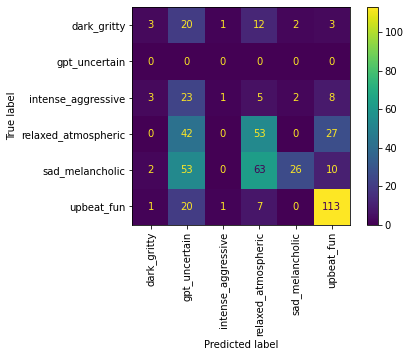

In [708]:
plot_conf_mat(os_gpt_w_stats["sentiment"], os_gpt_w_stats["gpt_result"])

In [709]:
get_total_usage_price_usd(os_gpt_w_stats)

2.1470535

## Stats

In [712]:
import matplotlib.pyplot as plt
import numpy as np

In [734]:
categories = ['zs_gpt_base', 'zs_gpt_w_stats', 'os_gpt_w_stats', 'fs_gpt_w_stats']
avg_prompt_tokens = [
    zs_gpt_df['gpt_prompt_tokens'].mean(), 
    zs_gpt_w_stats['gpt_prompt_tokens'].mean(),
    os_gpt_w_stats['gpt_prompt_tokens'].mean(),
    fs_gpt_w_stats['gpt_prompt_tokens'].mean()
]

sum_prompt_tokens = [
    zs_gpt_df['gpt_prompt_tokens'].sum(), 
    zs_gpt_w_stats['gpt_prompt_tokens'].sum(),
    os_gpt_w_stats['gpt_prompt_tokens'].sum(),
    fs_gpt_w_stats['gpt_prompt_tokens'].sum()
]

total_cost = [
    get_total_usage_price_usd(zs_gpt_df),
    get_total_usage_price_usd(zs_gpt_w_stats),
    get_total_usage_price_usd(os_gpt_w_stats),
    get_total_usage_price_usd(fs_gpt_w_stats),
]

C:\Users\HedonisT\AppData\Local\Temp\ipykernel_26056\3925357899.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(categories, rotation=45, ha='right')
C:\Users\HedonisT\AppData\Local\Temp\ipykernel_26056\3925357899.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(categories, rotation=45, ha='right')
C:\Users\HedonisT\AppData\Local\Temp\ipykernel_26056\3925357899.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(categories, rotation=45, ha='right')


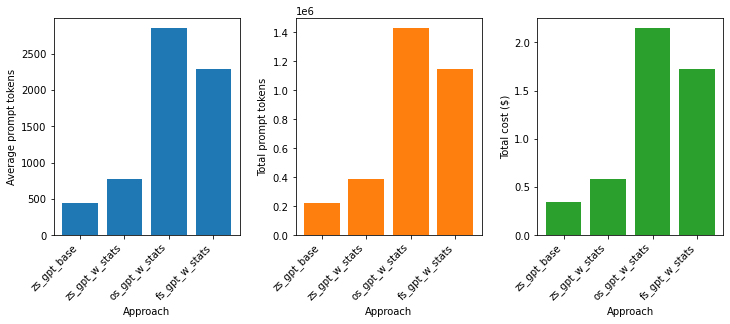

In [736]:
# Set the figure size
plt.figure(figsize=(12, 4))

# Define a color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Create a (1, 3) matrix of subplots
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)

# Plot the bar plots for avg_prompt_tokens
ax1.bar(categories, avg_prompt_tokens, color=colors[0])
ax1.set_xlabel('Approach')
ax1.set_ylabel('Average prompt tokens')
ax1.set_xticklabels(categories, rotation=45, ha='right')

# Plot the bar plots for sum_prompt_tokens
ax2.bar(categories, sum_prompt_tokens, color=colors[1])
ax2.set_xlabel('Approach')
ax2.set_ylabel('Total prompt tokens')
ax2.set_xticklabels(categories, rotation=45, ha='right')

# Plot the bar plots for total_tokens
ax3.bar(categories, total_cost, color=colors[2])
ax3.set_xlabel('Approach')
ax3.set_ylabel('Total cost ($)')
ax3.set_xticklabels(categories, rotation=45, ha='right')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Show the plot
plt.show()

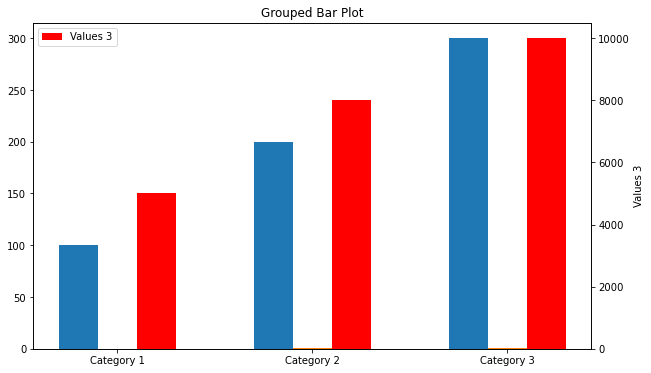

In [717]:
# Data for the grouped bar plot
categories = ['Category 1', 'Category 2', 'Category 3']
values_1 = [100, 200, 300]
values_2 = [0.1, 0.3, 0.5]
values_3 = [5000, 8000, 10000]

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the width of each bar
width = 0.2

# Set the positions of the bars for each category
x = np.arange(len(categories))

# Plot the grouped bars for each category and value
plt.bar(x - width, values_1, width=width, align='center', label='Values 1')
plt.bar(x, values_2, width=width, align='center', label='Values 2')

# Create a secondary y-axis for the third set of values
ax = plt.gca().twinx()
ax.bar(x + width, values_3, width=width, align='center', label='Values 3', color='red')

# Set the x-axis tick labels and position them at the center of each group
plt.xticks(x, categories)

# Set the labels and title
plt.xlabel('Categories')
plt.ylabel('Values 1 and 2')
ax.set_ylabel('Values 3')
plt.title('Grouped Bar Plot')

# Set the legend
plt.legend(loc='upper left')

# Show the plot
plt.show()